# Import

In [12]:
import json
import re
import ast
from tqdm import tqdm
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Data

In [13]:
# Charger les données traitées pour inspection
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Afficher un exemple
example_idx = 0  # Modifier cet indice pour voir d'autres exemples
example = processed_data[example_idx]

# Afficher avec une mise en forme claire
print("=== Exemple traité ===")
print("Tokenized Text:")
print(example['tokenized_text'])
print("\nNER Spans:")
for span in example['ner']:
    print(f" - Start: {span[0]}, End: {span[1]}, Entity Type: {span[2]}")
print("\nNegative Entities:")
print(example['negative'])

=== Exemple traité ===
Tokenized Text:
['Q', ':', 'Position', 'character', 'based', 'on', 'enemy', 'coordinates', 'in', 'lua', 'I', 'have', 'written', 'a', 'function', 'here', 'which', 'should', 'turn', 'my', 'character', 'based', 'on', 'enemy', 'coordinates', 'but', 'it', "'", 's', 'not', 'perfect', 'because', 'it', 'does', 'not', 'always', 'turn', 'where', 'I', 'want', 'it', 'to', 'and', 'perhaps', 'there', 'is', 'a', 'better', 'way', 'of', 'writing', 'it', 'local', 'myPosition', '=', '{', 'x', '=', '350', ',', 'y', '=', '355', '}', 'local', 'enemyPosition', '=', '{', 'x', '=', '352', ',', 'y', '=', '354', '}', 'local', 'xValue', ',', 'yValue', ',', 'xDir', ',', 'yDir', ',', 'dir', 'if', 'myPosition', '.', 'x', '>', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'elseif', 'myPosition', '.', 'x', '<', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'else', 'xValue', '='

faut allez à lendroit ou est defini le model puis vous pouvez exec la suite dans lordre

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = GLiNER(pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768)
# Initialiser le modèle
model.to(device)

c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


GLiNER(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropou

In [16]:
def analyze_dataset(processed_data):
    """
    Analyse des statistiques du dataset processed_data.
    """
    token_lengths = [len(entry["tokenized_text"]) for entry in processed_data]
    entity_counts = [len(entry["ner"]) for entry in processed_data]
    unique_entity_counts = [len(set(entity for _, _, entity in entry["ner"])) for entry in processed_data]
    entity_types = {}

    # Analyser les types d'entités
    for entry in processed_data:
        for _, _, entity in entry["ner"]:
            if entity not in entity_types:
                entity_types[entity] = 0
            entity_types[entity] += 1

    # Trier les types d'entités par occurrences décroissantes
    sorted_entity_types = dict(sorted(entity_types.items(), key=lambda item: item[1], reverse=True))

    # Calculer les statistiques
    stats = {
        "average_token_length": sum(token_lengths) / len(token_lengths),
        "min_token_length": min(token_lengths),
        "max_token_length": max(token_lengths),
        "average_entities_per_sequence": sum(entity_counts) / len(entity_counts),
        "min_entities_per_sequence": min(entity_counts),
        "max_entities_per_sequence": max(entity_counts),
        "average_unique_entities_per_sequence": sum(unique_entity_counts) / len(unique_entity_counts),
        "min_unique_entities_per_sequence": min(unique_entity_counts),
        "max_unique_entities_per_sequence": max(unique_entity_counts),
        "entity_type_distribution": sorted_entity_types,
    }

    # Affichage des résultats
    print("Analyse du dataset :")
    print(f"Longueur moyenne des 'tokenized_text' : {stats['average_token_length']:.2f} tokens")
    print(f"Longueur minimale des 'tokenized_text' : {stats['min_token_length']} tokens")
    print(f"Longueur maximale des 'tokenized_text' : {stats['max_token_length']} tokens")
    print(f"Nombre moyen d'entités par séquence : {stats['average_entities_per_sequence']:.2f}")
    print(f"Nombre minimal d'entités par séquence : {stats['min_entities_per_sequence']}")
    print(f"Nombre maximal d'entités par séquence : {stats['max_entities_per_sequence']}")
    print(f"Nombre moyen d'entités uniques par séquence : {stats['average_unique_entities_per_sequence']:.2f}")
    print(f"Nombre minimal d'entités uniques par séquence : {stats['min_unique_entities_per_sequence']}")
    print(f"Nombre maximal d'entités uniques par séquence : {stats['max_unique_entities_per_sequence']}")
    print("Répartition des types d'entités (triée par fréquence décroissante) :")
    for entity, count in stats["entity_type_distribution"].items():
        print(f"  - {entity}: {count} occurrences")

    return stats

# Charger les données générées précédemment
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Exemple d'utilisation
dataset_stats = analyze_dataset(processed_data)


Analyse du dataset :
Longueur moyenne des 'tokenized_text' : 202.95 tokens
Longueur minimale des 'tokenized_text' : 1 tokens
Longueur maximale des 'tokenized_text' : 983 tokens
Nombre moyen d'entités par séquence : 20.48
Nombre minimal d'entités par séquence : 0
Nombre maximal d'entités par séquence : 321
Nombre moyen d'entités uniques par séquence : 5.17
Nombre minimal d'entités uniques par séquence : 0
Nombre maximal d'entités uniques par séquence : 25
Répartition des types d'entités (triée par fréquence décroissante) :
  - concept: 43743 occurrences
  - Person: 40263 occurrences
  - person: 38936 occurrences
  - Organization: 38259 occurrences
  - Location: 32023 occurrences
  - organization: 31526 occurrences
  - product: 28823 occurrences
  - location: 28170 occurrences
  - variable: 21974 occurrences
  - Concept: 15370 occurrences
  - object: 15115 occurrences
  - Product: 12304 occurrences
  - technology: 11391 occurrences
  - Date: 10597 occurrences
  - chemical: 9881 occurrenc

In [17]:
from transformers import AutoTokenizer
import torch
from tqdm import tqdm
import json

def prepare_data_for_training(processed_data, model, max_length=128, max_entity_per_seq = 10):
    input_ids, labels, entity_tensors, attention_masks = [], [], [], []
    entity_masks, sentence_masks = [], []

    # Créer un mapping des types d'entités vers des entiers
    entity_types = {entity for entry in processed_data for _, _, entity in entry["ner"]}
    special_tokens = [f"[ENT] {entity}" for entity in entity_types]
    model.tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
    model.encoder.resize_token_embeddings(len(model.tokenizer))

    for entry in tqdm(processed_data, desc="Processing Data", unit="entry"):
        tokenized_text = entry["tokenized_text"]
        ner_spans = entry["ner"]
                
        # Générer le tensor de labels
        label_tensor = torch.zeros(max_length, dtype=torch.long)
        current_entity_id = []
        current_entity_str = []

        for start, end, entity_type in ner_spans:
            if start < max_length and end < max_length and len(current_entity_str)<max_entity_per_seq:
                entity_token_id = model.tokenizer.convert_tokens_to_ids(f'[ENT] {entity_type}')
                label_tensor[start:end + 1] = entity_token_id

                if entity_token_id not in current_entity_id:
                    current_entity_id.append(entity_token_id)
                if entity_type not in current_entity_str:
                    current_entity_str.append(entity_type)

        entity_tokens = " ".join(f"[ENT] {et}" for et in current_entity_str)
        
        # Tokeniser la séquence principale
        encoded = model.tokenizer(
            tokenized_text, return_tensors="pt", padding="max_length", truncation=True, 
            is_split_into_words=True, add_special_tokens=False
        )

        word_ids = encoded.word_ids()
        first_subtoken_ids = [
            encoded["input_ids"][0, i].item() for i, word_id in enumerate(word_ids) 
            if word_id is not None and (i == 0 or word_ids[i - 1] != word_id)
        ]

        encoded_entity = model.tokenizer(
            entity_tokens, return_tensors="pt", padding="max_length", truncation=True, 
            is_split_into_words=False, add_special_tokens=False
        )

        if len(current_entity_str) != len(encoded_entity["input_ids"][0]) or len(tokenized_text) != len(first_subtoken_ids):
            print("error, not same size")
            continue

        encoded_entity = encoded_entity["input_ids"][0].tolist() + [0]*(max_entity_per_seq-len(current_entity_str))

        sep_id = model.tokenizer.convert_tokens_to_ids(f'[SEP]')

        combined_ids = (
            encoded_entity +
            [sep_id] +
            first_subtoken_ids
        )

        if len(combined_ids) != max_entity_per_seq + len(first_subtoken_ids) + 1:
            print("error, not same size")
            continue

        deleted_ids = max(len(combined_ids) - max_length,0)
        combined_ids = combined_ids[:max_length]
        combined_ids += [0] * (max_length - len(combined_ids))

        # Créer l'attention mask
        attention_mask = [1 if id != 0 else 0 for id in combined_ids]

        # Masques spécifiques pour les entités et la phrase
        entity_mask = [1 if i < len(current_entity_str) else 0 for i in range(len(combined_ids))]
        sentence_mask = [1 if i > len(encoded_entity) and combined_ids[i] != 0 and combined_ids[i] != sep_id else 0 
                         for i in range(len(combined_ids))]

        # Vérification des tailles
        if sum(entity_mask) != len(current_entity_str):
            print(f"Entity mask size mismatch: {sum(entity_mask)} != {len(current_entity_str)}")
            continue
        if sum(sentence_mask) != len(tokenized_text)-deleted_ids:
            print(f"Sentence mask size mismatch: {sum(sentence_mask)} != {len(tokenized_text)-deleted_ids}")
            continue

        current_entity_id = current_entity_id + [0]*(max_entity_per_seq-len(current_entity_str))

        # Convertir les entités en un tensor
        entity_tensor = torch.tensor(current_entity_id, dtype=torch.long)
        
        # Ajouter les données
        input_ids.append(torch.tensor(combined_ids, dtype=torch.long))
        labels.append(label_tensor)
        entity_tensors.append(entity_tensor)
        attention_masks.append(torch.tensor(attention_mask, dtype=torch.long))
        entity_masks.append(torch.tensor(entity_mask, dtype=torch.long))
        sentence_masks.append(torch.tensor(sentence_mask, dtype=torch.long))

    return (
        torch.stack(input_ids), 
        torch.stack(labels), 
        entity_tensors, 
        torch.stack(attention_masks), 
        torch.stack(entity_masks), 
        torch.stack(sentence_masks)
    )



# Charger les données générées précédemment
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Préparer les données avec suivi d'avancement
input_ids, labels, entity_tensors, attention_masks, entity_masks, sentence_masks = prepare_data_for_training(processed_data, model)


Processing Data:   0%|          | 0/45889 [00:00<?, ?entry/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing Data:  10%|▉         | 4390/45889 [00:15<02:24, 287.13entry/s]

error, not same size


Processing Data:  34%|███▍      | 15512/45889 [00:53<01:40, 302.23entry/s]

error, not same size


Processing Data:  38%|███▊      | 17419/45889 [01:00<01:36, 294.50entry/s]

error, not same size


Processing Data:  53%|█████▎    | 24214/45889 [01:23<01:12, 299.33entry/s]

error, not same size


Processing Data:  64%|██████▍   | 29358/45889 [01:40<00:54, 303.49entry/s]

error, not same size


Processing Data:  73%|███████▎  | 33406/45889 [01:54<00:42, 296.06entry/s]

error, not same size


Processing Data:  76%|███████▌  | 34913/45889 [01:59<00:37, 294.79entry/s]

error, not same size


Processing Data:  88%|████████▊ | 40322/45889 [02:18<00:18, 303.49entry/s]

error, not same size


Processing Data: 100%|██████████| 45889/45889 [02:36<00:00, 292.32entry/s]


In [18]:
print(len(model.tokenizer))
print(len(input_ids))
print(len(entity_tensors))

143177
45881
45881


In [19]:
# Afficher les formes des tensors principaux
print(f"Forme de input_ids : {input_ids.shape}")
print(f"Forme de attention_masks : {attention_masks.shape}")
print(f"Forme de labels : {labels.shape}")
print(f"Forme de entity_masks : {entity_masks.shape}")
print(f"Forme de sentence_masks : {sentence_masks.shape}")

# Afficher un exemple pour les tensors principaux
print("\nExemple de input_ids (première entrée) :")
print(input_ids[0])

print("\nExemple de attention_masks (première entrée) :")
print(attention_masks[0])

print("\nExemple de labels (première entrée) :")
print(labels[0])

# Afficher un exemple pour les entity_tensors
print("\nExemple de entity_tensors (première entrée) :")
print(entity_tensors[0])

# Afficher un exemple pour les entity_masks
print("\nExemple de entity_masks (première entrée) :")
print(entity_masks[0])

# Afficher un exemple pour les sentence_masks
print("\nExemple de sentence_masks (première entrée) :")
print(sentence_masks[0])

Forme de input_ids : torch.Size([45881, 128])
Forme de attention_masks : torch.Size([45881, 128])
Forme de labels : torch.Size([45881, 128])
Forme de entity_masks : torch.Size([45881, 128])
Forme de sentence_masks : torch.Size([45881, 128])

Exemple de input_ids (première entrée) :
tensor([138308, 136301, 140848,      0,      0,      0,      0,      0,      0,
             0,      2,   1729,    877,  18172,   1470,    636,    277,   4648,
         14321,    267,  96792,    273,    286,   1223,    266,   1571,    422,
           319,    403,    930,    312,   1470,    636,    277,   4648,  14321,
           304,    278,    382,   1550,    298,    801,    401,    278,    490,
           298,    489,    930,    399,    273,    409,    278,    264,    263,
          1733,    343,    269,    266,    493,    384,    265,    898,    278,
           588,    312,   1842,  13856,   1204,   1842,   7351,    366,   2982,
          1842,  40059,  15805,    588,   4648,   1842,  13856,   1204,   184

# Dataset and Dataloader

In [20]:
proportion = 0.1

In [21]:
from torch.utils.data import DataLoader, Dataset, random_split
import torch

class NERDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels, entities,entity_masks,sentence_masks , max_span_length=2):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.entity_masks = entity_masks
        self.sentence_masks =sentence_masks
        self.labels = labels  # Liste des labels pour chaque token
        self.entities = entities  # Liste des entités uniques
        self.max_span_length = max_span_length

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        token_labels = self.labels[idx]  # Labels token-par-token
        entity_ids = self.entities[idx]  # Entités pour cet exemple

        num_tokens = len(input_id) - len(entity_ids) - 1
        spans = [
            (start, end)
            for start in range(num_tokens)
            for end in range(start, min(start + self.max_span_length, num_tokens))
        ]
        num_spans = len(spans)
        num_entities = len(entity_ids)

        # Matrice binaire : spans x entities
        binary_labels = torch.zeros(num_spans, num_entities, dtype=torch.float)

        for span_idx, (start, end) in enumerate(spans):
            span_labels = token_labels[start:end + 1]
            for entity_idx, entity_id in enumerate(entity_ids):
                if all((label == entity_id and label != 0)  for label in span_labels):
                    binary_labels[span_idx, entity_idx] = 1

        return input_id, attention_mask, spans, entity_ids, binary_labels, sentence_masks, entity_masks


In [22]:
ind = int(len(input_ids) * proportion)

In [23]:
# Créer le dataset
dataset = NERDataset(input_ids[:ind], attention_masks[:ind], labels[:ind], entity_tensors[:ind],entity_masks[:ind],sentence_masks[:ind])

# Exemple de récupération d'une entrée
input_id, attention_mask, spans, entity_ids, binary_labels, sentence_masks, entity_masks = dataset[0]

print("Input ID:", input_id)
print("Spans:", spans)
print("Entity IDs:", entity_ids)
print("Binary Labels:", binary_labels)

Input ID: tensor([138308, 136301, 140848,      0,      0,      0,      0,      0,      0,
             0,      2,   1729,    877,  18172,   1470,    636,    277,   4648,
         14321,    267,  96792,    273,    286,   1223,    266,   1571,    422,
           319,    403,    930,    312,   1470,    636,    277,   4648,  14321,
           304,    278,    382,   1550,    298,    801,    401,    278,    490,
           298,    489,    930,    399,    273,    409,    278,    264,    263,
          1733,    343,    269,    266,    493,    384,    265,    898,    278,
           588,    312,   1842,  13856,   1204,   1842,   7351,    366,   2982,
          1842,  40059,  15805,    588,   4648,   1842,  13856,   1204,   1842,
         42091,    366,   2982,   1842,  50238,  15805,    588,   1204,    366,
          2982,    366,   1204,    366,   2982,    366,  30791,    337,    312,
           323,   1204,   2108,   4648,    323,   1204,    393,   1204,   1842,
           312,    323,   1204

In [24]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = zip(*batch)

    # Trouver les tailles maximales pour le padding
    max_len = max(len(ids) for ids in input_ids)  # Longueur max des tokens
    max_spans = max(len(s) for s in spans)  # Nombre max de spans
    max_entities = max(len(e) for e in entity_ids)  # Nombre max d'entités

    # Padding des input_ids et attention_masks
    # padded_input_ids = torch.stack([
    #     torch.cat([ids, torch.zeros(max_len - len(ids), dtype=torch.long)])
    #     for ids in input_ids
    # ])
    # padded_attention_masks = torch.stack([
    #     torch.cat([mask, torch.zeros(max_len - len(mask), dtype=torch.long)])
    #     for mask in attention_masks
    # ])

    # Padding des spans
    # spans = torch.stack([
    #     torch.cat([torch.tensor(s, dtype=torch.long), torch.zeros((max_spans - len(s), 2), dtype=torch.long)])
    #     for s in spans
    # ])

    # Padding des entity_ids
    # padded_entity_ids = torch.stack([
    #     torch.cat([e, torch.zeros(max_entities - len(e), dtype=torch.long)])
    #     for e in entity_ids
    # ])

    # Padding des binary_labels
    # binary_labels = torch.stack([
    #     torch.cat([
    #         torch.cat([bl, torch.zeros(max_spans - bl.size(0), bl.size(1))], dim=0) if bl.size(0) < max_spans else bl,
    #         torch.zeros(max_spans, max_entities - bl.size(1)) if bl.size(1) < max_entities else torch.zeros(0)
    #     ], dim=1)
    #     for bl in binary_labels
    # ])

        # Conversion en tensors
        #spans = [torch.tensor(s, dtype=torch.long) for s in spans]
    input_ids = torch.stack([ids.clone().detach() for ids in input_ids])
    attention_masks = torch.stack([mask.clone().detach() for mask in attention_masks]) 
    entity_ids = torch.stack([e.clone().detach() for e in entity_ids])
    binary_labels = torch.stack([bl.clone().detach() for bl in binary_labels])
    sentence_masks = torch.stack([sm.clone().detach() for sm in sentence_masks])
    entity_masks = torch.stack([em.clone().detach() for em in entity_masks])
    spans = torch.tensor([span for span in spans], dtype=torch.long)

    return input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks


In [25]:
# Définir les proportions pour le train, validation et test
train_ratio = 0.8  # 80% des données pour l'entraînement
val_ratio = 0.1    # 10% des données pour la validation
test_ratio = 0.1   # 10% des données pour le test

# Calculer les tailles des différents ensembles
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Diviser les données en train, validation, et test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Créer les DataLoaders pour chaque ensemble
batch_size = 8  # Ajuster selon vos besoins
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Vérification des tailles
print(f"Train size: {len(train_loader)}")
print(f"Validation size: {len(val_loader)}")
print(f"Test size: {len(test_loader)}")


Train size: 459
Validation size: 58
Test size: 58


# Model

## architecture model

In [11]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

class GLiNER(nn.Module):
    def __init__(self, pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768, dropout_rate=0.4):
        super(GLiNER, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        self.encoder_output_size = self.encoder.config.hidden_size
        self.entity_ffn = nn.Sequential(
            nn.Linear(self.encoder_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.span_ffn = nn.Sequential(
            nn.Linear(2 * self.encoder_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.sigmoid = nn.Sigmoid()
        
        self.span_max_length = span_max_length
        # self.loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

        pos_weight = torch.tensor([5], dtype=torch.float32)  # Convertir en tenseur si nécessaire
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids, attention_masks, entity_types, spans, sentence_masks, entity_masks, binary_labels=None):
        # print("Input IDs shape:", input_ids.shape)
        # print("Attention mask shape:", attention_masks.shape)
        # Passer input_ids et attention_masks au modèle
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_masks)
        token_embeddings = outputs.last_hidden_state
    
        entity_embeddings, text_embeddings = self.split_embeddings(token_embeddings,len(entity_types[0]))
        

        refined_entity_embeddings = self.entity_ffn(entity_embeddings)
        
        span_scores,scores_logit = self.compute_span_scores(refined_entity_embeddings, text_embeddings, spans)

        if binary_labels is not None:
            #loss = self.compute_loss(span_scores, binary_labels)
            loss = self.compute_loss(scores_logit,binary_labels)
            return span_scores, loss
        
        return span_scores


    def split_embeddings(self, token_embeddings, num_entity_types = 25):
        entity_embeddings = token_embeddings[:, 0:num_entity_types, :]
        text_embeddings = token_embeddings[:, num_entity_types + 1:, :]
        
        return entity_embeddings, text_embeddings

    
    def compute_span_scores(self, entity_embeddings, text_embeddings, spans):
        """
        Calcule les scores des spans en une seule passe vectorisée, 
        en supposant que tous les spans sont valides.
        """
        batch_size, text_length, hidden_size = text_embeddings.shape

        # Conversion des spans en tensor directement
        spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)

        # Récupération des embeddings des spans
        i_indices = spans_tensor[:, :, 0].unsqueeze(-1).expand(-1, -1, hidden_size)  # (batch, num_spans, hidden_size)
        j_indices = spans_tensor[:, :, 1].unsqueeze(-1).expand(-1, -1, hidden_size)

        start_embeddings = torch.gather(text_embeddings, 1, i_indices)  # (batch, num_spans, hidden_size)
        end_embeddings = torch.gather(text_embeddings, 1, j_indices)    # (batch, num_spans, hidden_size)

        # Concaténer les embeddings des extrémités et passer dans la FFN
        span_reprs = torch.cat([start_embeddings, end_embeddings], dim=-1)  # (batch, num_spans, 2 * hidden_size)
        span_reprs = self.span_ffn(span_reprs)                              # (batch, num_spans, hidden_size)

        # Calcul des scores pour toutes les entités
        scores = torch.einsum("bsh,beh->bse", span_reprs, entity_embeddings)  # (batch, num_spans, num_entity_types)

        # Appliquer la sigmoïde pour les scores finaux
        span_scores = self.sigmoid(scores)

        return span_scores,scores


    def compute_loss(self, span_scores, binary_labels):
        """
        Calcul de la perte binaire cross-entropy entre les scores et les étiquettes.
        """
        # print(f"span_scores shape: {span_scores.shape}")
        # print(f"binary_labels shape: {binary_labels.shape}")

        # Appliquer la perte
        loss = self.loss_fn(span_scores, binary_labels)
        return loss

    def compute_loss(self, span_scores, binary_labels):
        """
        Calcul de la perte binaire cross-entropy avec des poids pour la classe positive.
        """
        # BCEWithLogitsLoss attend des scores bruts (sans Sigmoid), donc on peut retirer self.sigmoid ici.
        loss = self.loss_fn(span_scores, binary_labels)
        return loss


## train

In [26]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Hyperparamètres
num_epochs = 5
# learning_rate = 1e-5

# # Optimiseur et scheduler
# optimizer = AdamW(model.parameters(), lr=learning_rate)
# scheduler = get_scheduler(
#     "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
# )

# Calcul des étapes totales
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

# Optimiseur avec deux taux d'apprentissage
optimizer = AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.entity_ffn.parameters(), 'lr': 5e-5},
    {'params': model.span_ffn.parameters(), 'lr': 5e-5},
])

# Scheduler cosinus
scheduler = get_scheduler(
    "cosine", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)


# Fonction d'entraînement avec tqdm
def train_epoch(model, train_loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    # Ajout de tqdm pour afficher la progression
    progress_bar = tqdm(train_loader, desc="Training", unit="batch")
    for batch in progress_bar:
        input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

        optimizer.zero_grad()

        _, loss = model(
            input_ids=input_ids,
            attention_masks=attention_masks,
            entity_types=entity_ids,
            spans=spans,
            binary_labels=binary_labels,
            sentence_masks=sentence_masks,
            entity_masks=entity_masks
        )

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Mise à jour de la barre de progression
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    return avg_loss

# # Boucle d'entraînement avec tqdm
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     train_loss = train_epoch(model, train_loader, optimizer, scheduler)
#     print(f"Train Loss: {train_loss:.4f}")

max_steps = 30000
global_step = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    print(f"Train Loss: {train_loss:.4f}")
    
    global_step += len(train_loader)
    if global_step >= max_steps:
        print("Reached maximum training steps.")
        break


Epoch 1/5


Training:   0%|          | 0/459 [00:00<?, ?batch/s]C:\Users\doria\AppData\Local\Temp\ipykernel_25076\594497121.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)
Training: 100%|██████████| 459/459 [05:37<00:00,  1.36batch/s, Batch Loss=0.146] 


Train Loss: 0.2570
Epoch 2/5


Training: 100%|██████████| 459/459 [05:37<00:00,  1.36batch/s, Batch Loss=0.146] 


Train Loss: 0.1163
Epoch 3/5


Training: 100%|██████████| 459/459 [05:41<00:00,  1.34batch/s, Batch Loss=0.0962]


Train Loss: 0.1103
Epoch 4/5


Training: 100%|██████████| 459/459 [05:38<00:00,  1.36batch/s, Batch Loss=0.104] 


Train Loss: 0.1071
Epoch 5/5


Training: 100%|██████████| 459/459 [05:38<00:00,  1.36batch/s, Batch Loss=0.0831]

Train Loss: 0.1059


In [27]:
# import torch
# from torch.optim import AdamW
# from transformers import get_scheduler
# from tqdm import tqdm

# # Hyperparamètres
# num_epochs = 1
# max_steps = 30000
# global_step = 0

# # Calcul des étapes totales
# num_training_steps = len(train_loader) * num_epochs
# num_warmup_steps = int(0.1 * num_training_steps)

# # Optimiseur avec deux taux d'apprentissage
# optimizer = AdamW([
#     {'params': model.encoder.parameters(), 'lr': 1e-5},
#     {'params': model.entity_ffn.parameters(), 'lr': 5e-5},
#     {'params': model.span_ffn.parameters(), 'lr': 5e-5},
# ])

# # Scheduler cosinus
# scheduler = get_scheduler(
#     "cosine", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
# )

# # Scaler pour la précision mixte
# scaler = torch.cuda.amp.GradScaler()


# # Fonction d'entraînement avec AMP et tqdm
# def train_epoch(model, train_loader, optimizer, scheduler, scaler):
#     model.train()
#     total_loss = 0

#     # Ajout de tqdm pour afficher la progression
#     progress_bar = tqdm(train_loader, desc="Training", unit="batch")
#     for batch in progress_bar:
#         input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

#         optimizer.zero_grad()

#         # Précision mixte avec autocast
#         with torch.cuda.amp.autocast():
#             span_scores, loss = model(
#                 input_ids=input_ids,
#                 attention_masks=attention_masks,
#                 entity_types=entity_ids,
#                 spans=spans,
#                 binary_labels=binary_labels,
#                 sentence_masks=sentence_masks,
#                 entity_masks=entity_masks
#             )

#         # Backpropagation avec le scaler
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         scheduler.step()

#         total_loss += loss.item()

#         # Mise à jour de la barre de progression
#         progress_bar.set_postfix({"Batch Loss": loss.item()})

#     avg_loss = total_loss / len(train_loader)
#     return avg_loss


# # Boucle d'entraînement avec AMP
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler)
#     print(f"Train Loss: {train_loss:.4f}")

#     global_step += len(train_loader)
#     if global_step >= max_steps:
#         print("Reached maximum training steps.")
#         break


## test

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Fonction pour calculer la précision, le rappel, le F1-score, l'exactitude et la matrice de confusion
def calculate_metrics(binary_scores, binary_labels):
    # Déplacer les tensors vers le CPU avant de les convertir en NumPy
    binary_scores_flat = binary_scores.cpu().flatten()
    binary_labels_flat = binary_labels.cpu().flatten()

    # Calcul des métriques
    precision = precision_score(binary_labels_flat, binary_scores_flat)
    recall = recall_score(binary_labels_flat, binary_scores_flat)
    f1 = f1_score(binary_labels_flat, binary_scores_flat)
    accuracy = accuracy_score(binary_labels_flat, binary_scores_flat)

    # Matrice de confusion
    cm = confusion_matrix(binary_labels_flat, binary_scores_flat)

    return precision, recall, f1, accuracy, cm

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(confusion_matrix, normalize=False):
    # Si normalisation est activée
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix:")      
    else:
        # Conversion explicite pour s'assurer d'afficher les entiers
        confusion_matrix = confusion_matrix.astype(int)
        print("Confusion Matrix (Integers):")

    print(confusion_matrix)

    plt.figure(figsize=(6, 4))
    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    # Affichage de la matrice de confusion avec format ajusté
    sns.heatmap(confusion_matrix, annot=True, fmt='.4f' if normalize else 'g', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [30]:
def test_epoch(model, test_loader):
    model.eval()  # Passer en mode évaluation
    total_loss = 0
    test_loss = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_accuracy = 0  # Pour l'accuracy
    confusion_matrix_total = torch.zeros(2, 2)  # Confusion matrix for binary classification

    progress_bar = tqdm(test_loader, desc="Testing", unit="batch")
    with torch.no_grad():  # Désactiver les gradients pour la phase de test
        for batch in progress_bar:
            input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

            span_scores, loss = model(
                input_ids=input_ids,
                attention_masks=attention_masks,
                entity_types=entity_ids,
                spans=spans,
                binary_labels=binary_labels,
                sentence_masks=sentence_masks,
                entity_masks=entity_masks
            )

            total_loss += loss.item()

            # Calcul des autres métriques
            binary_scores = (span_scores >= 0.5).int()  # Convertir les scores en prédictions binaires
            precision, recall, f1, accuracy, cm = calculate_metrics(binary_scores, binary_labels)
            
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            total_accuracy += accuracy  # Ajout de l'accuracy
            confusion_matrix_total += torch.tensor(cm)

            # Mise à jour de la barre de progression
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(test_loader)
    # Moyenne des métriques
    average_precision = total_precision / len(test_loader)
    average_recall = total_recall / len(test_loader)
    average_f1 = total_f1 / len(test_loader)
    average_accuracy = total_accuracy / len(test_loader)  # Moyenne de l'accuracy
    confusion_matrix_total = confusion_matrix_total.numpy()

    return avg_loss, average_precision, average_recall, average_f1, average_accuracy, confusion_matrix_total


In [31]:
test_loss, test_precision, test_recall, test_f1, test_accuracy, cm = test_epoch(model, test_loader)

Testing:   0%|          | 0/58 [00:00<?, ?batch/s]C:\Users\doria\AppData\Local\Temp\ipykernel_25076\594497121.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)
Testing:   2%|▏         | 1/58 [00:00<00:41,  1.39batch/s, Batch Loss=0.117]C:\Users\doria\AppData\Local\Temp\ipykernel_25076\594497121.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)
Testing:   3%|▎         | 2/58 [00:01<00:38,  1.46batch/s, Batch Loss=0.142]C:\Users\doria\AppData\Local\Temp\

Test Loss: 0.1125
Test Precision: 0.2376
Test Recall: 0.4052
Test F1 Score: 0.2912
Test Accuracy: 0.9745
Confusion Matrix (Integers):
[[1038709   18700]
 [   8586    5805]]


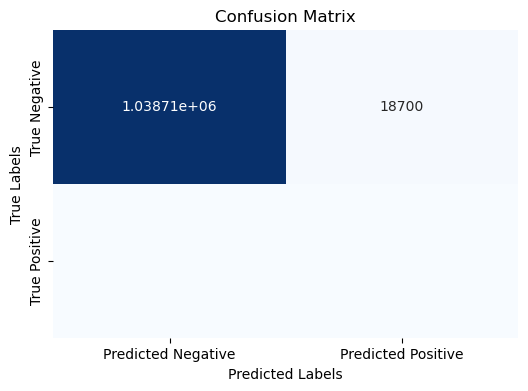

In [34]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(cm,False)

- cm[0, 0] = TN
- cm[0, 1] = FP
- cm[1, 0] = FN
- cm[1, 1] = TP

[[TN,FP]

 [FN,TP]]


# Save & Load

In [ ]:
import torch
#load 
model = torch.load("model_fullNewBCE9.pth")

In [ ]:
# Sauvegarder le modèle complet
torch.save(model, "model_fullNewBCE9.pth")
# Sauvegarder le modèle
torch.save(model.state_dict(), "modelNewBCE9.pth")

# test

In [35]:
# Phrase d'exemple
sentence = "Alain Farley works at McGill University"
entity_types_to_detect = ["person", "organization"]

In [35]:
sentence = "Marie Dupont is a data scientist at OpenAI and she specializes in Python programming."
entity_types_to_detect = ["person", "organization","programming language"]


In [66]:
sentence = "John Smith works at Google and has expertise in machine learning and Java."
entity_types_to_detect = ["person", "organization", "programming language"]

In [46]:
sentence = "Sundar Pichai is the CEO of Google"
entity_types_to_detect = ["person", "organization", "title"]


In [36]:
max_entity_per_seq = 10
max_length = 128
max_span_length = 2
threshold_score = 0.5

In [37]:
current_entity_id = []
current_entity_str = []

for entity_type in entity_types_to_detect:
    entity_token_id = model.tokenizer.convert_tokens_to_ids(f'[ENT] {entity_type}')
    if entity_token_id not in current_entity_id:
        current_entity_id.append(entity_token_id)
    if entity_type not in current_entity_str:
        current_entity_str.append(entity_type)

entity_tokens = " ".join(f"[ENT] {et}" for et in current_entity_str)

# Tokeniser la séquence principale
encoded = model.tokenizer(
    sentence.split(), return_tensors="pt", padding="max_length", truncation=True, 
    is_split_into_words=True, add_special_tokens=False
)

word_ids = encoded.word_ids()
first_subtoken_ids = [
    encoded["input_ids"][0, i].item() for i, word_id in enumerate(word_ids) 
    if word_id is not None and (i == 0 or word_ids[i - 1] != word_id)
]

encoded_entity = model.tokenizer(
    entity_tokens, return_tensors="pt", padding="max_length", truncation=True, 
    is_split_into_words=False, add_special_tokens=False
)

encoded_entity = encoded_entity["input_ids"][0].tolist() + [0]*(max_entity_per_seq-len(current_entity_str))

sep_id = model.tokenizer.convert_tokens_to_ids(f'[SEP]')

combined_ids = (
    encoded_entity +
    [sep_id] +
    first_subtoken_ids
)

deleted_ids = max(len(combined_ids) - max_length,0)
combined_ids = combined_ids[:max_length]
combined_ids += [0] * (max_length - len(combined_ids))

# Créer l'attention mask
attention_mask = [1 if id != 0 else 0 for id in combined_ids]

# Masques spécifiques pour les entités et la phrase
entity_mask = [1 if i < len(current_entity_str) else 0 for i in range(len(combined_ids))]
sentence_mask = [1 if i > len(encoded_entity) and combined_ids[i] != 0 and combined_ids[i] != sep_id else 0 
                    for i in range(len(combined_ids))]

current_entity_id = current_entity_id + [0]*(max_entity_per_seq-len(current_entity_str))

# Convertir les entités en un tensor
entity_tensor = torch.tensor(current_entity_id, dtype=torch.long)

# Ajouter les données
input_ids_tensor = torch.tensor(combined_ids, dtype=torch.long)
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
entity_mask_tensor =torch.tensor(entity_mask, dtype=torch.long)
sentence_mask_tensor = torch.tensor(sentence_mask, dtype=torch.long)


In [38]:
# for batch in test_loader:
#     input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]
#     input_ids_tensor = input_ids[0]
#     attention_mask_tensor = attention_masks[0]
#     entity_mask_tensor = entity_masks[0]
#     sentence_mask_tensor = sentence_masks[0]
#     entity_tensor = entity_ids[0]
#     binary_labels = binary_labels
#     # Convertir binary_labels[0] en liste et afficher
#     binary_labels_list = binary_labels[0].tolist()  # Conversion en liste
#     print(binary_labels_list)  # Affichage de la liste
#     break


In [39]:
# Conversion des IDs en texte
entity_ids_list = entity_tensor.tolist()  # Convertir le tenseur en liste
entity_types_to_detect = [
    model.tokenizer.decode([entity_id], skip_special_tokens=False)
    for entity_id in entity_ids_list
    if entity_id != 0
]

# Affichage des résultats
print("Filtered Entity IDs:", [entity_id for entity_id in entity_ids_list if entity_id != 0])
print("Decoded Texts:", entity_types_to_detect)

# Affichage des résultats
print("Entity IDs:", entity_ids_list)
print("Decoded Texts:", entity_types_to_detect)


Filtered Entity IDs: [135381, 132031]
Decoded Texts: ['[ENT] person', '[ENT] organization']
Entity IDs: [135381, 132031, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Texts: ['[ENT] person', '[ENT] organization']


In [40]:
num_tokens = len(input_ids_tensor) - len(entity_tensor) - 1
spans = [
    (start, end)
    for start in range(num_tokens)
    for end in range(start, min(start + max_span_length, num_tokens))
]

spans_tensor = torch.tensor(spans, dtype=torch.long)

In [41]:
# Passage en mode évaluation
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)
# Préparation des données de test
# Assurez-vous que `input_ids_tensor`, `attention_mask_tensor`, `entity_tensor`, 
# `entity_mask_tensor`, `sentence_mask_tensor`, et `spans` soient bien définis.

with torch.no_grad():  # Pas besoin de calculer les gradients en mode test
    span_scores = model(
        input_ids=input_ids_tensor.unsqueeze(0).to(device),  # Ajout d'une dimension batch
        attention_masks=attention_mask_tensor.unsqueeze(0).to(device),
        entity_types=entity_tensor.unsqueeze(0).to(device),
        spans=spans_tensor.unsqueeze(0).to(device),
        sentence_masks=sentence_mask_tensor.unsqueeze(0).to(device),
        entity_masks=entity_mask_tensor.unsqueeze(0).to(device)
    )

# span_scores contient les scores prédites pour chaque span et chaque entité
print("Span scores:", span_scores)

# Conversion des span scores en valeurs binaires
binary_span_scores = (span_scores > threshold_score).int()

# Affichage des résultats
print("Binary Span Scores:", binary_span_scores)

# Comptage des valeurs 1 dans tout le tenseur
num_ones = binary_span_scores.sum().item()

# Affichage des résultats
print("Nombre de 1:", num_ones)

# Création d'un masque avec des 0 et 1 représentant la valeur la plus élevée dans chaque liste
# Initialisation d'un masque de mêmes dimensions que span_scores
max_mask = torch.zeros_like(span_scores, dtype=torch.int)

# Parcourir chaque batch, span et entité pour identifier les indices des max
for i in range(span_scores.size(1)):  # Dimension des spans
    for j in range(span_scores.size(2)):  # Dimension des entités
        # Trouver l'indice de la valeur maximale dans la liste
        max_index = torch.argmax(span_scores[0, i, :])  # Corrigé pour les dimensions
        # Définir 1 à cet indice dans le masque
        max_mask[0, i, max_index] = 1  # Corrigé pour les dimensions

# Appliquer le masque sur binary_span_scores
masked_binary_span_scores = binary_span_scores * max_mask

# Affichage des résultats
print("Masked Binary Span Scores:", masked_binary_span_scores)


# Affichage des résultats
print("Masked Binary Span Scores:", masked_binary_span_scores)



C:\Users\doria\AppData\Local\Temp\ipykernel_25076\594497121.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)


Span scores: tensor([[[6.4497e-01, 6.6152e-01, 5.1539e-05,  ..., 5.1539e-05,
          5.1539e-05, 5.1539e-05],
         [6.5916e-01, 6.6882e-01, 1.7789e-05,  ..., 1.7789e-05,
          1.7789e-05, 1.7789e-05],
         [6.7870e-01, 6.8624e-01, 6.7114e-06,  ..., 6.7114e-06,
          6.7114e-06, 6.7114e-06],
         ...,
         [2.9928e-05, 2.5976e-05, 6.9125e-16,  ..., 6.9125e-16,
          6.9125e-16, 6.9125e-16],
         [2.9928e-05, 2.5976e-05, 6.9125e-16,  ..., 6.9125e-16,
          6.9125e-16, 6.9125e-16],
         [2.9928e-05, 2.5976e-05, 6.9125e-16,  ..., 6.9125e-16,
          6.9125e-16, 6.9125e-16]]], device='cuda:0')
Binary Span Scores: tensor([[[1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.int32)
Nombre de 1: 12
Masked Binary Span Scores: tensor([[[0, 1, 0,  ..., 0, 0, 0],


In [42]:
# # Convertir les tenseurs en numpy
# binary_scores_np = binary_span_scores[0].cpu().numpy()
# binary_labels_np = binary_labels[0].cpu().numpy()

# # Aplatir les matrices pour les rendre 1D
# y_pred = binary_scores_np.flatten()  # Prédictions
# y_true = binary_labels_np.flatten()  # Labels réels

# # Calculer la matrice de confusion
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Afficher la matrice de confusion
# print("Confusion Matrix:")
# print(conf_matrix)

In [43]:
import pandas as pd  # Utilisé pour afficher les données en tableau lisible

# Conversion en liste pour un affichage plus lisible
binary_span_scores_list = masked_binary_span_scores.cpu().numpy().tolist()

# Affichage structuré avec les spans associés
print("Binary Span Scores with Spans:")
for i, example in enumerate(binary_span_scores_list):  # Pour chaque exemple dans le batch
    print(f"Example {i + 1}:")
    
    # Création d'une structure tabulaire
    table_data = []
    for j, span_scores in enumerate(example):  # Pour chaque span dans l'exemple
        associated_span = spans[j]  # Associer le span avec l'indice
        # Ajout des données du span et des scores associés
        table_data.append([associated_span] + span_scores[:len(entity_types_to_detect)])
    
    # Création d'un DataFrame pour une meilleure lisibilité
    columns = ["Span"] + entity_types_to_detect  # Colonnes : Span + types d'entités
    df = pd.DataFrame(table_data, columns=columns)
    print(df.to_string(index=False))  # Affichage sans l'index



Binary Span Scores with Spans:
Example 1:
      Span  [ENT] person  [ENT] organization
    (0, 0)             0                   1
    (0, 1)             0                   1
    (1, 1)             0                   1
    (1, 2)             0                   0
    (2, 2)             0                   0
    (2, 3)             0                   0
    (3, 3)             0                   0
    (3, 4)             0                   0
    (4, 4)             1                   0
    (4, 5)             1                   0
    (5, 5)             1                   0
    (5, 6)             0                   0
    (6, 6)             0                   0
    (6, 7)             0                   0
    (7, 7)             0                   0
    (7, 8)             0                   0
    (8, 8)             0                   0
    (8, 9)             0                   0
    (9, 9)             0                   0
   (9, 10)             0                   0
  (10, 10)   

In [44]:
# Longueur limite
max_index = len(first_subtoken_ids)

# Filtrage et affichage des résultats
for i, example in enumerate(binary_span_scores_list):
    print(f"Example {i + 1}:")
    
    # Création d'une structure tabulaire
    table_data = []
    for j, span_scores in enumerate(example):
        associated_span = spans[j]
        if associated_span[0] < max_index and associated_span[1] < max_index:  # Condition de filtre
            table_data.append([associated_span] + span_scores[:len(entity_types_to_detect)])
    
    # Création du DataFrame
    columns = ["Span"] + entity_types_to_detect
    df = pd.DataFrame(table_data, columns=columns)
    print(df.to_string(index=False))

Example 1:
  Span  [ENT] person  [ENT] organization
(0, 0)             0                   1
(0, 1)             0                   1
(1, 1)             0                   1
(1, 2)             0                   0
(2, 2)             0                   0
(2, 3)             0                   0
(3, 3)             0                   0
(3, 4)             0                   0
(4, 4)             1                   0
(4, 5)             1                   0
(5, 5)             1                   0
